**Importing Necessary Libraries**

In [ ]:
import os
import gzip
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import yaml
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, accuracy_score, f1_score)
from sklearn.model_selection import train_test_split

from collections import defaultdict

**DOWNLOAD AND UNZIP**

In [ ]:
# Download training images
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz
# Download training labels
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-labels-idx1-ubyte.gz
# Download test images
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz
# Download test labels
!wget https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz

--2024-10-14 08:14:39--  https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-images-idx3-ubyte.gz [following]
--2024-10-14 08:14:39--  https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [application/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M   168MB/s    in 0.

**MAKING DRECTORY NAMED FASHION**

In [ ]:
!mkdir -p fashion

**MOVING THE FILES TO FASHION**

In [ ]:
!mv train-images-idx3-ubyte.gz fashion/
!mv train-labels-idx1-ubyte.gz fashion/
!mv t10k-images-idx3-ubyte.gz fashion/
!mv t10k-labels-idx1-ubyte.gz fashion/

**LOAD THE DATASET**

In [ ]:
def load_mnist(path, kind='train'):

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
# print(load_mnist('/content/fashion', kind='train'))
images_train, labels_train = load_mnist('/content/fashion', kind='train')

print("Shape of the Training Images: ", images_train.shape)
print()
print("Shape of the Training Labels: ", labels_train.shape)
print((labels_train[:10]))

print()

images_test, labels_test = load_mnist('/content/fashion', kind='t10k')

print("Shape of the Testing Images: ", images_test.shape)
print("Shape of the Testing Labels: ", labels_test.shape)



Shape of the Training Images:  (60000, 784)

Shape of the Training Labels:  (60000,)
[9 0 0 3 0 2 7 2 5 5]

Shape of the Testing Images:  (10000, 784)
Shape of the Testing Labels:  (10000,)


In [ ]:
classes = os.listdir("fashion/")
classes.sort()
print(classes)

['t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz']


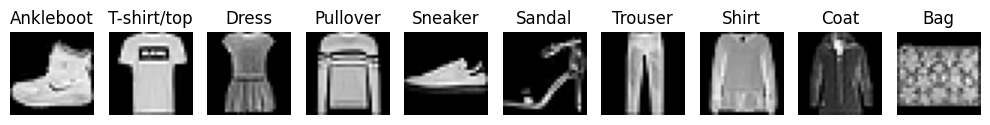

In [ ]:
class_names =["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankleboot"]

my_dict = defaultdict(list)

# my_dict['a'].append(2)
# my_dict["a"].append(3)



for i in range(len(labels_train)): #from the 6000 lables
  index = labels_train[i] #0th label which is 9 (ankleboot)
  my_dict[index].append(images_train[i].reshape(28, 28)) #in the key of "9" the value is ankleboot's array
  # print(my_dict)
  if len(my_dict[index]) == 1: #making sure only one sample is taken
    if len(my_dict) == 10: #when 10 different images are taken break
      break

# print(my_dict[9])

plt.figure(figsize=(10, 10))

# Plot each image with its label
for i, (label, img) in enumerate(my_dict.items()):
    plt.subplot(1, 10, i + 1)  # 1 row, 10 columns
    plt.imshow(img[0], cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [ ]:
print(images_train.shape)
# image = images_train[0].reshape(28, 28)
# plt.figure(figsize=(6, 6))
# plt.imshow(image, cmap='gray')
# plt.title('Fashion MNIST Image')
# plt.axis('off')  # Hide axis
# plt.show()

(60000, 784)


**PREPROCESS THE DATA**

In [ ]:
def preprocess_images(images: np.array) -> np.array:

  images = images.astype('float32')/255.0

  # images = (images - np.mean(images))/np.std(images)

  # images = images.reshape(-1, 28*28)

  return images

images_train_2 = preprocess_images(images_train)
images_test_2 = preprocess_images(images_test)
# print(images[[0]])

**SEETING UP THE DATA**

In [ ]:
X_train = images_train_2
X_val = images_test_2
y_train = labels_train
y_val = labels_test

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)


(60000, 784)
(10000, 784)
(60000,)
(10000,)


**KNN CLASSIFIER**

In [ ]:
def euclidean_distance(image: np.array, images: np.array) -> np.array:
    """
    Compute the euclidean distance between the image and the images.

    :param image: The image.
    :type image: np.array
    :param images: The images.
    :type images: np.array

    :return: The distances.
    :rtype: np.array
    """
    return np.sqrt(np.sum((images - image)**2, axis=1))

def k_nearest_neighbor(
    new_image: np.array,
    train_images: np.array,
    train_labels: np.array, k: int) -> int:

    distances = euclidean_distance(new_image, train_images)
    indices = np.argsort(distances)
    nearest_neighbors = train_labels[indices[:k]]
    values, counts = np.unique(nearest_neighbors, return_counts = True)
    index = np.argmax(counts)
    predicted_label = values[index]
    # print(values)
    # print(counts)
    # print(index)
    # print(predicted_label)
    return predicted_label

# k_nearest_neighbor(X_val[0], X_train, y_train, 1)

**K = 1**

In [ ]:
n = 300
# y_pred = k_nearest_neighbor(X_val[0], X_train, y_train, 1)
# print("Correclty Predicted: ", y_pred)
# print(f"Predicted: {class_names[y_pred]}, True: {class_names[y_val[0]]}")

y_pred_list = []
y_true_list = []
# n = len(X_val)
n = 500
correct_label = 0
for i in range (n):
  y_pred = k_nearest_neighbor(X_val[i], X_train, y_train, 1)

  y_pred_list.append(y_pred)
  y_true_list.append(y_val[i])

  if class_names[y_pred] == class_names[y_val[i]]:
    correct_label += 1

  print(f"Predicted: {class_names[y_pred]}, True: {class_names[y_val[i]]}")

print("Correctly labeled: ", correct_label)

Predicted: Ankleboot, True: Ankleboot
Predicted: Pullover, True: Pullover
Predicted: Trouser, True: Trouser
Predicted: Trouser, True: Trouser
Predicted: Shirt, True: Shirt
Predicted: Trouser, True: Trouser
Predicted: Coat, True: Coat
Predicted: Shirt, True: Shirt
Predicted: Sandal, True: Sandal
Predicted: Sneaker, True: Sneaker
Predicted: Coat, True: Coat
Predicted: Sneaker, True: Sandal
Predicted: Sandal, True: Sneaker
Predicted: Dress, True: Dress
Predicted: Coat, True: Coat
Predicted: Trouser, True: Trouser
Predicted: Pullover, True: Pullover
Predicted: Pullover, True: Coat
Predicted: Bag, True: Bag
Predicted: T-shirt/top, True: T-shirt/top
Predicted: Pullover, True: Pullover
Predicted: Sandal, True: Sandal
Predicted: Sneaker, True: Sneaker
Predicted: Ankleboot, True: Ankleboot
Predicted: Trouser, True: Trouser
Predicted: Pullover, True: Coat
Predicted: Coat, True: Shirt
Predicted: T-shirt/top, True: T-shirt/top
Predicted: Ankleboot, True: Ankleboot
Predicted: Dress, True: Dress
Pre

In [ ]:
conf_matrix_1 = confusion_matrix(y_true_list, y_pred_list)

print("Confusion Matrix: \n", conf_matrix_1, "\n")

accuracy_1 = accuracy_score(y_true_list, y_pred_list)

print("The Accuracy Score: ", accuracy_1, "\n")

f1_1 = f1_score(y_true_list, y_pred_list, average='macro')

print("F1 Score:", f1_1)

Confusion Matrix: 
 [[42  0  1  3  1  0  8  0  0  0]
 [ 0 52  0  0  0  0  0  0  0  0]
 [ 1  0 54  1  2  0  7  0  0  0]
 [ 1  0  1 39  3  0  2  0  0  0]
 [ 0  0 10  2 39  0  6  0  0  0]
 [ 0  0  0  0  0 36  0  2  0  1]
 [ 5  0  6  2  2  0 32  0  0  0]
 [ 0  0  0  0  0  1  0 43  0  3]
 [ 0  0  0  0  0  0  0  0 44  0]
 [ 0  0  0  0  0  0  0  3  0 45]] 

The Accuracy Score:  0.852 

F1 Score: 0.8592640763880791


**K = 3**

In [ ]:
y_pred_list2 = []
y_true_list2 = []
# n = len(X_val)
correct_label = 0
for i in range (n):
  y_pred = k_nearest_neighbor(X_val[i], X_train, y_train, 3)

  y_pred_list2.append(y_pred)
  y_true_list2.append(y_val[i])

  if class_names[y_pred] == class_names[y_val[i]]:
    correct_label += 1

  print(f"Predicted: {class_names[y_pred]}, True: {class_names[y_val[i]]}")

print("Correctly labeled: ", correct_label)

Predicted: Ankleboot, True: Ankleboot
Predicted: Pullover, True: Pullover
Predicted: Trouser, True: Trouser
Predicted: Trouser, True: Trouser
Predicted: Shirt, True: Shirt
Predicted: Trouser, True: Trouser
Predicted: Coat, True: Coat
Predicted: Shirt, True: Shirt
Predicted: Sandal, True: Sandal
Predicted: Sneaker, True: Sneaker
Predicted: Coat, True: Coat
Predicted: Sandal, True: Sandal
Predicted: Sandal, True: Sneaker
Predicted: Dress, True: Dress
Predicted: Coat, True: Coat
Predicted: Trouser, True: Trouser
Predicted: Pullover, True: Pullover
Predicted: Pullover, True: Coat
Predicted: Bag, True: Bag
Predicted: T-shirt/top, True: T-shirt/top
Predicted: Pullover, True: Pullover
Predicted: Sneaker, True: Sandal
Predicted: Sneaker, True: Sneaker
Predicted: Ankleboot, True: Ankleboot
Predicted: Trouser, True: Trouser
Predicted: Pullover, True: Coat
Predicted: Shirt, True: Shirt
Predicted: T-shirt/top, True: T-shirt/top
Predicted: Ankleboot, True: Ankleboot
Predicted: Dress, True: Dress
Pr

In [ ]:
conf_matrix_2 = confusion_matrix(y_true_list2, y_pred_list2)

print("Confusion Matrix: \n", conf_matrix_2, "\n")

accuracy_2 = accuracy_score(y_true_list2, y_pred_list2)

print("The Accuracy Score: ", accuracy_2, "\n")

f1_2 = f1_score(y_true_list2, y_pred_list2, average='macro')

print("F1 Score:", f1_2)

Confusion Matrix: 
 [[47  0  1  2  0  0  5  0  0  0]
 [ 1 51  0  0  0  0  0  0  0  0]
 [ 1  0 56  1  3  0  4  0  0  0]
 [ 2  0  0 41  2  0  1  0  0  0]
 [ 0  0  8  2 42  0  5  0  0  0]
 [ 0  0  0  0  0 35  0  3  0  1]
 [ 4  0  6  1  2  0 33  0  1  0]
 [ 0  0  0  0  0  1  0 42  0  4]
 [ 0  0  1  0  0  0  0  0 43  0]
 [ 0  0  0  0  0  0  0  3  0 45]] 

The Accuracy Score:  0.87 

F1 Score: 0.8744449001118655


**K = 5**

In [ ]:
y_pred_list3 = []
y_true_list3 = []
# n = len(X_val)
correct_label = 0
for i in range (n):
  y_pred = k_nearest_neighbor(X_val[i], X_train, y_train, 5)

  y_pred_list3.append(y_pred)
  y_true_list3.append(y_val[i])

  if class_names[y_pred] == class_names[y_val[i]]:
    correct_label += 1

  print(f"Predicted: {class_names[y_pred]}, True: {class_names[y_val[i]]}")

print("Correctly labeled: ", correct_label)

Predicted: Ankleboot, True: Ankleboot
Predicted: Pullover, True: Pullover
Predicted: Trouser, True: Trouser
Predicted: Trouser, True: Trouser
Predicted: Shirt, True: Shirt
Predicted: Trouser, True: Trouser
Predicted: Coat, True: Coat
Predicted: Shirt, True: Shirt
Predicted: Sandal, True: Sandal
Predicted: Sneaker, True: Sneaker
Predicted: Coat, True: Coat
Predicted: Sandal, True: Sandal
Predicted: Sandal, True: Sneaker
Predicted: Dress, True: Dress
Predicted: Coat, True: Coat
Predicted: Trouser, True: Trouser
Predicted: Pullover, True: Pullover
Predicted: Shirt, True: Coat
Predicted: Bag, True: Bag
Predicted: T-shirt/top, True: T-shirt/top
Predicted: Pullover, True: Pullover
Predicted: Sneaker, True: Sandal
Predicted: Sneaker, True: Sneaker
Predicted: Ankleboot, True: Ankleboot
Predicted: Trouser, True: Trouser
Predicted: Pullover, True: Coat
Predicted: Shirt, True: Shirt
Predicted: T-shirt/top, True: T-shirt/top
Predicted: Ankleboot, True: Ankleboot
Predicted: Dress, True: Dress
Predi

In [ ]:
conf_matrix_3 = confusion_matrix(y_true_list3, y_pred_list3)

print("Confusion Matrix: \n", conf_matrix_3, "\n")

accuracy_3 = accuracy_score(y_true_list3, y_pred_list3)

print("The Accuracy Score: ", accuracy_3, "\n")

f1_3 = f1_score(y_true_list3, y_pred_list3, average='macro')

print("F1 Score:", f1_3)

Confusion Matrix: 
 [[51  0  1  1  0  0  1  0  1  0]
 [ 0 51  0  1  0  0  0  0  0  0]
 [ 1  0 54  1  5  0  4  0  0  0]
 [ 1  0  0 42  2  0  1  0  0  0]
 [ 0  0  6  3 44  0  4  0  0  0]
 [ 0  0  0  0  0 35  1  2  0  1]
 [ 4  0  6  1  3  0 33  0  0  0]
 [ 0  0  0  0  0  1  0 44  0  2]
 [ 0  0  1  0  0  0  1  0 42  0]
 [ 0  0  0  0  0  0  0  3  0 45]] 

The Accuracy Score:  0.882 

F1 Score: 0.8860447487873897


**K = 7**

In [ ]:
y_pred_list4 = []
y_true_list4 = []
# n = len(X_val)
correct_label = 0
for i in range (n):
  y_pred = k_nearest_neighbor(X_val[i], X_train, y_train, 7)

  y_pred_list4.append(y_pred)
  y_true_list4.append(y_val[i])

  if class_names[y_pred] == class_names[y_val[i]]:
    correct_label += 1

  print(f"Predicted: {class_names[y_pred]}, True: {class_names[y_val[i]]}")

print("Correctly labeled: ", correct_label)

Predicted: Ankleboot, True: Ankleboot
Predicted: Pullover, True: Pullover
Predicted: Trouser, True: Trouser
Predicted: Trouser, True: Trouser
Predicted: Shirt, True: Shirt
Predicted: Trouser, True: Trouser
Predicted: Coat, True: Coat
Predicted: Shirt, True: Shirt
Predicted: Sandal, True: Sandal
Predicted: Sneaker, True: Sneaker
Predicted: Coat, True: Coat
Predicted: Sneaker, True: Sandal
Predicted: Sandal, True: Sneaker
Predicted: Dress, True: Dress
Predicted: Coat, True: Coat
Predicted: Trouser, True: Trouser
Predicted: Pullover, True: Pullover
Predicted: Pullover, True: Coat
Predicted: Bag, True: Bag
Predicted: T-shirt/top, True: T-shirt/top
Predicted: Pullover, True: Pullover
Predicted: Sneaker, True: Sandal
Predicted: Sneaker, True: Sneaker
Predicted: Ankleboot, True: Ankleboot
Predicted: Trouser, True: Trouser
Predicted: Pullover, True: Coat
Predicted: Shirt, True: Shirt
Predicted: T-shirt/top, True: T-shirt/top
Predicted: Ankleboot, True: Ankleboot
Predicted: Dress, True: Dress
P

In [ ]:
conf_matrix_4 = confusion_matrix(y_true_list4, y_pred_list4)

print("Confusion Matrix: \n", conf_matrix_4, "\n")

accuracy_4 = accuracy_score(y_true_list4, y_pred_list4)

print("The Accuracy Score: ", accuracy_4, "\n")

f1_4 = f1_score(y_true_list4, y_pred_list4, average='macro')

print("F1 Score:", f1_4)

Confusion Matrix: 
 [[52  0  1  0  1  0  0  0  1  0]
 [ 0 52  0  0  0  0  0  0  0  0]
 [ 1  0 53  0  3  0  8  0  0  0]
 [ 1  0  0 42  2  0  1  0  0  0]
 [ 0  0  7  4 41  0  5  0  0  0]
 [ 0  0  0  0  0 33  1  4  0  1]
 [ 4  0  6  2  2  0 33  0  0  0]
 [ 0  0  0  0  0  1  0 42  0  4]
 [ 0  0  1  0  0  0  0  0 43  0]
 [ 0  0  0  0  0  0  0  2  0 46]] 

The Accuracy Score:  0.874 

F1 Score: 0.8774171004468672


**PLOTTING A GRAPH**

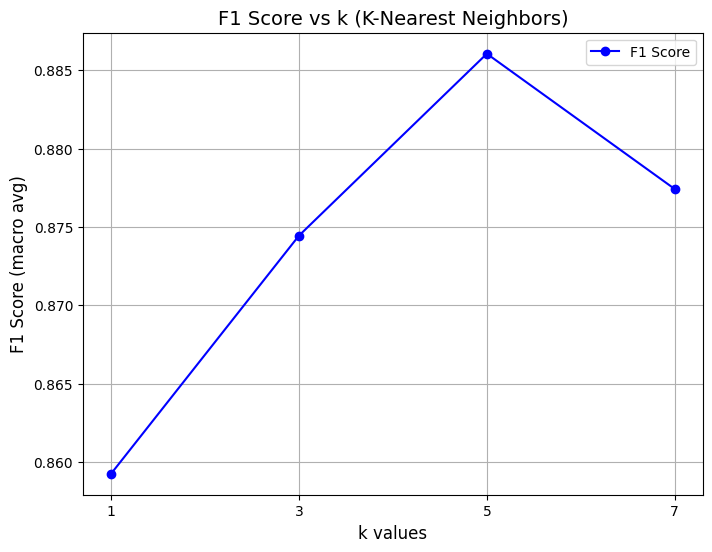

In [ ]:
k_values = [1, 3, 5, 7]

f1_avg = [f1_1, f1_2, f1_3, f1_4]

plt.figure(figsize=(8, 6))
plt.plot(k_values, f1_avg, marker='o', linestyle='-', color='b', label='F1 Score')

plt.xlabel('k values', fontsize=12)
plt.ylabel('F1 Score (macro avg)', fontsize=12)
plt.title('F1 Score vs k (K-Nearest Neighbors)', fontsize=14)

plt.grid(True)
plt.xticks(k_values)
plt.legend()
plt.show()